# 1. IMPORTS & CONFIGURATIONS

## 1.1 IMPORTS

In [1]:
import os
import warnings
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
warnings.filterwarnings("ignore", category=UserWarning)

#torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from timm.layers import DropPath, to_2tuple, trunc_normal_
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchmetrics.functional.image import peak_signal_noise_ratio as psnr
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
import torchvision.models as models


#other imports
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
import multiprocessing as mp
import os
import numpy as np
from collections.abc import Callable
from tqdm.auto import tqdm 

## 1.2 CONFIGURATIONS

In [2]:
# paths
DATA_PATH = "/kaggle/input/rain14000"
CHECKPOINT_PATH = "./Checkpoints"
LOAD_CHECKPOINT_PATH = "/kaggle/input/cs406-epoch-129-finetune/pytorch/default/1/last_checkpoint.pt"

# data
DATA_NAME = 'Rain14000' # Rain14000 - Rain100H - Rain100L - Test100 - Test1200 - Test2800 - Nature - TimeTest

# model
###########
# Note:
#       - Ảnh phải chia hết cho patch_size
#       - Ảnh phải chia hết cho windows_size
###########

DIM = 96
L_RNN = 3
N_RTB = 6
WINDOW_SIZE = 7
NUM_HEADS = 2
PATCH_SIZE = 1  

# training config
TRAINING_IMAGE_SIZE = 56  
DTYPE = torch.cuda.FloatTensor
BATCH_SIZE = 32
WARMUP_EPOCHS=10
EPOCHS = 100 
LR = 0.0001
W_DECAY = 1e-2
SEED = 2026

FROM_CHECKPONT = False
ES_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5
MIN_LR = 1e-6

# linh tinh
NUM_PROC = mp.cpu_count()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams['figure.figsize'] = (16, 9)

In [3]:
def seed_everything(seed):
    # 1. Python & Random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 2. Numpy
    np.random.seed(seed)
    
    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # cho multi-GPU
    torch.use_deterministic_algorithms(True)
    
    # 4. CuDNN 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
print(DEVICE)

cuda


# 2. DATA PREPARATION

## 2.1 Utils

In [4]:
class RainDataset(Dataset):
    def __init__(self, dataset_name, data_path, image_size, mode='train'):
        self.dataset_name = dataset_name
        self.mode = mode
        self.image_size = image_size
        
        # 1. Định nghĩa cấu trúc folder tập trung
        configs = {
            'Rain14000': {'in': 'input', 'out': 'output'},
            'Rain100L':  {'in': 'rain',  'out': 'norain'},
            'Rain100H':  {'in': 'rain',  'out': 'norain'},
            'Test100':   {'in': 'input', 'out': 'target'},
            'Test1200':  {'in': 'input', 'out': 'target'},
            'Test2800':  {'in': 'input', 'out': 'target'},
            'Nature':    {'in': '',      'out': ''}, 
            'TimeTest':  {'in': '',      'out': ''}
        }

        if dataset_name not in configs:
            raise ValueError(f"Dataset {dataset_name} không được hỗ trợ!")
        if mode not in ['train', 'val', 'test']:
            raise ValueError(f"{mode} không được hỗ trợ!")
        
        cfg = configs[dataset_name]
        data_path = Path(data_path)

        # 2. Xử lý logic đường dẫn linh hoạt
        if dataset_name in ['Nature', 'TimeTest']:
            self.input_dir = data_path
            self.target_dir = data_path
        elif dataset_name in ['Test100', 'Test1200', 'Test2800']:
            self.input_dir = Path.joinpath(data_path, cfg['in'])
            self.target_dir = Path.joinpath(data_path, cfg['out'])          
        else:
            self.input_dir = Path.joinpath(data_path, mode, cfg['in'])
            self.target_dir = Path.joinpath(data_path, mode, cfg['out'])

        # 3. Lấy danh sách file
        valid_extensions = ('.jpg', '.jpeg', '.png')
        self.file_names = sorted([
            f.name for f in self.input_dir.iterdir() 
            if f.suffix.lower() in valid_extensions
        ])
        print(f"✅ [{mode.upper()}] Đã tải {len(self.file_names)} ảnh từ {dataset_name}")

        self.input_paths = [Path.joinpath(self.input_dir, f) for f in self.file_names]
        self.target_paths = [Path.joinpath(self.target_dir, f) for f in self.file_names]
        
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):        
        # Đọc ảnh
        input_img = Image.open(self.input_paths[index]).convert('RGB')
        target_img = Image.open(self.target_paths[index]).convert('RGB')

        # 4. Logic Xử lý ảnh 
        if self.mode == 'train':
            # Random Crop
            w, h = input_img.size
            th, tw = self.image_size, self.image_size
            
            if w < tw or h < th:
                pad_w = max(0, tw - w)
                pad_h = max(0, th - h)

                padding = (0, 0, pad_w, pad_h) 
                input_img = TF.pad(input_img, padding, padding_mode='reflect')
                target_img = TF.pad(target_img, padding, padding_mode='reflect')

                i, j = 0, 0
            else:
                i = random.randint(0, h - th)
                j = random.randint(0, w - tw)
            
            input_img = TF.crop(input_img, i, j, th, tw)
            target_img = TF.crop(target_img, i, j, th, tw)

            # Random Flips
            if random.random() > 0.5:
                input_img = TF.hflip(input_img)
                target_img = TF.hflip(target_img)
            if random.random() > 0.5:
                input_img = TF.vflip(input_img)
                target_img = TF.vflip(target_img)
                
        elif self.mode == 'val':
            input_img = TF.center_crop(input_img, (self.image_size, self.image_size))
            target_img = TF.center_crop(target_img, (self.image_size, self.image_size))
        else:
            pass

        # 5. Chuyển sang Tensor [0, 1]
        input_tensor = TF.to_tensor(input_img)
        target_tensor = TF.to_tensor(target_img)

        return target_tensor, input_tensor

## 2.2 Create Dataloader

In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [6]:
train_dataset = RainDataset(DATA_NAME, DATA_PATH, image_size=TRAINING_IMAGE_SIZE, mode='train')
val_dataset = RainDataset(DATA_NAME, DATA_PATH, image_size=TRAINING_IMAGE_SIZE, mode='val')

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True, num_workers = NUM_PROC, persistent_workers = True, worker_init_fn=seed_worker)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=False, num_workers = NUM_PROC, persistent_workers = True, worker_init_fn=seed_worker)

✅ [TRAIN] Đã tải 10968 ảnh từ Rain14000
✅ [VAL] Đã tải 1371 ảnh từ Rain14000


**Sanity check**

In [7]:
def test_dataset(data_loader):
    print(f"--- Đang kiểm tra Dataset: {len(data_loader)} batch ---")
    try:
        for i, (target_data, input_data) in enumerate(data_loader):
            if i in [0, 10, 20, 30, 40, 50]:
                print(f"Batch size: {target_data.shape}") # Check shape: [B, C, H, W]
                
                # 2. Hiển thị thử 1 cặp ảnh để xem có bị biến dạng không
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(input_data[0].permute(1, 2, 0))
                ax[0].set_title("Input (Rainy)")
                ax[1].imshow(target_data[0].permute(1, 2, 0))
                ax[1].set_title("Target (Clean)")
                plt.show()
        print("=> Kiểm tra hoàn tất: Dataset hoạt động bình thường!")
    except Exception as e:
        print(f"Xảy ra lỗi: {e}")

In [8]:
# test_dataset(train_loader)

In [9]:
# test_dataset(val_loader)

# 3. Model

## 3.1 Transformer-based

In [10]:
#fully connected multilayer perceptron
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        #query, key, value share weights
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        #divide depths according to the number of heads
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        #attention score is calculated by taking the dot product between query and key
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        #add relative position bias into the attention score
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)
        #calculate a softmax version of the attention scores
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)
        #multiply attention with value and project x
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [11]:
class TransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion (H,W).
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=1., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        H, W = self.input_resolution
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)


    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C) #B L C
        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

## 3.2 Deraining model

**Step 1: Patch Embedding**

In [12]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, patch_size: int = 4, in_chans: int = 3, embed_dim: int = 96, norm_layer: Callable[..., nn.Module] | None = None):
        super().__init__()
        self.patch_size = to_2tuple(patch_size)
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(self.in_chans, self.embed_dim, kernel_size = self.patch_size, stride = self.patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(self.embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        if not (H % self.patch_size[0] == 0 and W % self.patch_size[1] == 0):
            raise ValueError(f"Image dimensions ({H}, {W}) must be divisible by patch_size {self.patch_size}")
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B C H W) -> (B dim Ph Pw) -> (B dim Ph*Pw) -> (B Ph*Pw dim)
        if self.norm is not None:
            x = self.norm(x)
        return x    # (B Ph*Pw dim)

**Step 2: Feature Extraction**

In [13]:
#patch embedding -> transformer -> patch unembedding
class BasicBlock(nn.Module):
    def __init__(self, dim: int, patch_resolution: tuple[int, int], num_heads: int, window_size: int):
        super().__init__()
        self.dim = dim
        self.patch_resolution = patch_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.transformer = TransformerBlock(self.dim, self.patch_resolution, self.num_heads, self.window_size)
    
    def forward(self, x):
        # x's shape: (B, PhPw, C)
        x = self.transformer(x)
        return x

In [14]:
#Basic Block -> basic block (with skip connection)
class ResidualLayer(nn.Module):
    def __init__(self, dim: int, patch_resolution: tuple[int, int], num_heads: int, window_size: int, l_recursion: int):
        super().__init__()
        self.dim = dim
        self.patch_resolution = patch_resolution
        self.H_patch, self.W_patch = patch_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.l_recursion = l_recursion

        self.block1 = BasicBlock(self.dim, self.patch_resolution, self.num_heads, self.window_size)
        self.block2 = BasicBlock(self.dim, self.patch_resolution, self.num_heads, self.window_size)
        self.conv_out = nn.Conv2d(self.dim, self.dim, 3, padding = 1)
        
    def forward(self, x):
        B, PhPW, C = x.shape
        
        shortcut = x
        for _ in range(self.l_recursion):
            x = self.block1(self.block2(x))
            x = torch.add(x, shortcut)
            
        #convolution at the end of each residual block
        x = x.transpose(1,2).view(B, C, self.H_patch, self.W_patch) # (B, PhPw, C) -> (B, C, PhPw) -> (B, C, Ph, Pw)
        x = self.conv_out(x).flatten(2).transpose(1, 2)
        return x

**Step 3: Patch Unembedding**

In [15]:
class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 96.
        unembed_dim (int): Number of linear projection output channels. Default: 3.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, patch_size: int = 4, in_chans: int = 96, unembed_dim: int = 3, norm_layer: Callable[..., nn.Module] | None = None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.unembed_dim = unembed_dim

        self.proj = nn.Conv2d(self.in_chans, self.unembed_dim, kernel_size=3, padding=1)
        self.sample_layer = nn.Upsample(scale_factor=self.patch_size, mode="bilinear") if patch_size != 1 else nn.Identity()
        if norm_layer is not None:
            self.norm = norm_layer(unembed_dim)
        else:
            self.norm = None

    def forward(self, x, x_size):
        B, PhPw, C = x.shape
        x = x.transpose(1, 2).view(B, C, x_size[0], x_size[1])  # B C Ph PW
        x = self.sample_layer(x) #B C H W
        x = self.proj(x)
        return x

**MAIN**

In [16]:
class DeepRecursiveTransformer(nn.Module):
    def __init__(self, dim: int, input_resolution: tuple[int, int], patch_size: int, l_recursion: int, n_RTB: int, num_heads: int, window_size: int):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.patch_size = patch_size
        self.l_recursion = l_recursion
        self.n_RTB = n_RTB
        self.num_heads = num_heads
        self.window_size = window_size
        
        self.patch_embed = PatchEmbed(patch_size = self.patch_size, in_chans = 3, embed_dim = self.dim)
        self.patch_unembed = PatchUnEmbed(patch_size = self.patch_size, in_chans = self.dim, unembed_dim = 3)

        self.patch_resolution = (input_resolution[0] // patch_size, input_resolution[1] // patch_size)
        self.RTB_block = nn.ModuleList()
        for _ in range(self.n_RTB):
            layer = ResidualLayer(self.dim, self.patch_resolution, self.num_heads, self.window_size, self.l_recursion)
            self.RTB_block.append(layer)

        #use imagenet mean and std for general domain normalisation
        self.normalise_layer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.denormalise_layer = transforms.Normalize((-0.485, -0.456, -0.406), (1./0.229, 1./0.224, 1./0.225))
        self.apply(self._init_weights)
        
    # weight initialisation scheme
    def _init_weights(self, l):
        if isinstance(l, nn.Linear):
            trunc_normal_(l.weight, std=.02)
            if l.bias is not None:
                nn.init.constant_(l.bias, 0)
        elif isinstance(l, nn.LayerNorm):
            nn.init.constant_(l.bias, 0)
            nn.init.constant_(l.weight, 1.0)
    
    def forward(self, x):
        B, C, H, W = x.shape

        x = self.normalise_layer(x)
        outer_shortcut = x

        x = self.patch_embed(x)
        inner_shortcut = x       # (B Ph*Pw dim)

        for i in range(len(self.RTB_block)):
            x = self.RTB_block[i](x)
            
        x=torch.add(x, inner_shortcut)
        x=self.patch_unembed(x, self.patch_resolution)    
        x=torch.add(x, outer_shortcut)
        x=self.denormalise_layer(x)
        return x #output shape (B, C, H, W)

In [17]:
net = DeepRecursiveTransformer(DIM, (TRAINING_IMAGE_SIZE, TRAINING_IMAGE_SIZE), PATCH_SIZE, L_RNN, N_RTB, NUM_HEADS, WINDOW_SIZE)
summary(net.to(DEVICE), (3, TRAINING_IMAGE_SIZE, TRAINING_IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 56, 56]               0
            Conv2d-2           [-1, 96, 56, 56]             384
        PatchEmbed-3             [-1, 3136, 96]               0
         LayerNorm-4             [-1, 3136, 96]             192
            Linear-5              [-1, 49, 288]          27,936
           Softmax-6            [-1, 2, 49, 49]               0
           Dropout-7            [-1, 2, 49, 49]               0
            Linear-8               [-1, 49, 96]           9,312
           Dropout-9               [-1, 49, 96]               0
  WindowAttention-10               [-1, 49, 96]               0
         Identity-11             [-1, 3136, 96]               0
        LayerNorm-12             [-1, 3136, 96]             192
           Linear-13             [-1, 3136, 96]           9,312
             GELU-14             [-1, 3

In [18]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total trainable params: {total_params:,}")

Total trainable params: 1,180,347


# 4. TRAINING

## 4.1 Utils

**Plot history**

In [19]:
def plot_history(history, save_path='./loss_history.png'):
    """
    Vẽ biểu đồ lịch sử loss với thang đo Log và hệ thống lưới chi tiết.
    """
    train_loss = history.get('train_loss', [])
    val_loss = history.get('val_loss', [])
    
    if not train_loss or not val_loss:
        print("=> Không có dữ liệu lịch sử để vẽ biểu đồ.")
        return

    epochs = range(1, len(train_loss) + 1)

    # Khởi tạo khung hình
    plt.figure(figsize=(10, 6))

    # Vẽ đường Train và Val Loss
    plt.plot(epochs, train_loss, 'b-s', label='Train Loss', markersize=5, linewidth=1.5)
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', markersize=5, linewidth=1.5)

    # Cấu hình thang đo Log
    plt.yscale('log') 
    
    # --- BẬT LƯỚI TẠI ĐÂY ---
    # which='both' để hiện cả lưới cho các mốc chính và mốc phụ của Log scale
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Cấu hình các nhãn và tiêu đề
    plt.title('Model Convergence (Log Scale)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss Value (Logarithmic)', fontsize=12)
    
    plt.legend(loc='upper right')

    # Tự động căn chỉnh
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close() # Giải phóng bộ nhớ sau khi lưu

    print(f"✅ Biểu đồ (Log Scale) đã được lưu tại: {save_path}")

**Load Checkpoint**

In [20]:
def load_ckp(checkpoint_fpath, model, optimizer, scheduler, device="cuda"):
    checkpoint = torch.load(checkpoint_fpath, map_location=device)
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    history = checkpoint.get('history', {'train_loss': [], 'val_loss': []})
    
    print(f"=> Đã tải thành công checkpoint tại Epoch {epoch}")
    
    return model, optimizer, scheduler, epoch, best_val_loss, early_stop_counter, history

**Trainer**

In [21]:
def network_training(
    net, train_loader, val_loader, optimiser, criterion,
    epochs=100, warmup_epochs=5,
    from_ckp=False,
    load_ckp_pth="./Checkpoints/last_checkpoint.pt",
    save_ckp_pth="./Checkpoints",
    device="cuda",
    early_stopping_patience=10,
    min_delta=1e-6,
    clip=1.0
):
    net.to(device)
    
    # Khởi tạo mặc định
    start_epoch = 0
    best_val_psnr = -float('inf') # Chuyển sang theo dõi PSNR tốt nhất
    early_stop_counter = 0
    history = {
        'train_loss': [], 'val_loss': [], 
        'val_psnr': [], 'val_ssim': []
    }

    save_ckp_pth = Path(save_ckp_pth)
    save_ckp_pth.mkdir(parents=True, exist_ok=True)
    
    # 1. Khởi tạo Scheduler (Cosine với Warmup)
    main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimiser, T_max=epochs - warmup_epochs, eta_min = MIN_LR)

    # 2. Logic RESUME
    if from_ckp and Path(load_ckp_pth).exists():
        print(f"Đang tải checkpoint từ: {load_ckp_pth}...")
        checkpoint = torch.load(load_ckp_pth, map_location=device)
        net.load_state_dict(checkpoint['state_dict'])
        optimiser.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        best_val_psnr = checkpoint.get('best_val_psnr', -float('inf'))
        history = checkpoint.get('history', history)
        print(f"Tiếp tục từ epoch {start_epoch}")

    epoch_pbar = tqdm(range(start_epoch, epochs), desc="Training Process", unit="epoch")

    for epoch in epoch_pbar:
        # --- WARMUP LOGIC ---
        if epoch < warmup_epochs:
            lr_scale = min(1.0, float(epoch + 1) / warmup_epochs)
            for pg in optimiser.param_groups:
                pg['lr'] = lr_scale * pg['initial_lr'] if 'initial_lr' in pg else lr_scale * LR

        # --- PHASE 1: TRAINING ---
        net.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        
        for target, net_input in train_pbar:
            target, net_input = target.to(device), net_input.to(device)
            
            optimiser.zero_grad()
            output = net(net_input)
            loss = criterion(output, target) 
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip)
            optimiser.step()

            train_loss += loss.item()
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)

        # --- PHASE 2: VALIDATION (PSNR/SSIM) ---
        net.eval()
        val_loss, total_psnr, total_ssim = 0.0, 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        
        with torch.no_grad():
            for target, net_input in val_pbar:
                target, net_input = target.to(device), net_input.to(device)
                output = net(net_input)
                
                # Tính Loss
                v_loss = criterion(output, target) 
                val_loss += v_loss.item()
                
                # Tính Metrics (PSNR/SSIM)
                total_psnr += psnr(output, target, data_range=1.0).item()
                total_ssim += ssim(output, target, data_range=1.0).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_psnr = total_psnr / len(val_loader)
        avg_ssim = total_ssim / len(val_loader)

        # --- CẬP NHẬT LOGGING ---
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_psnr'].append(avg_psnr)
        history['val_ssim'].append(avg_ssim)
        
        curr_lr = optimiser.param_groups[0]['lr']
        epoch_pbar.set_postfix({
            'PSNR': f"{avg_psnr:.2f}",
            'SSIM': f"{avg_ssim:.4f}",
            'LR': f"{curr_lr:.2e}"
        })

        tqdm.write(f"[EPOCH {epoch+1}]: PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f} | Loss: {avg_val_loss:.4f} | LR: {curr_lr:.4f}")
        
        # --- PHASE 3: SCHEDULER & CHECKPOINT ---
        if epoch >= warmup_epochs:
            main_scheduler.step()

        # Check cải thiện dựa trên PSNR (cao hơn là tốt hơn)
        is_best = avg_psnr > best_val_psnr + min_delta
        if is_best:
            best_val_psnr = avg_psnr
            early_stop_counter = 0
            tqdm.write(f"  [MỚI] Best PSNR: {best_val_psnr:.2f}")
        else:
            early_stop_counter += 1

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': optimiser.state_dict(),
            'best_val_psnr': best_val_psnr,
            'history': history
        }

        torch.save(checkpoint, save_ckp_pth / "last_checkpoint.pt")
        if is_best:
            torch.save(checkpoint, save_ckp_pth / "best_model.pt")

        # --- PHASE 4: EARLY STOPPING ---
        if early_stop_counter >= early_stopping_patience:
            tqdm.write(f"!!! Dừng sớm tại epoch {epoch+1} do PSNR không cải thiện !!!")
            break

    return history

## 4.2 Setup

In [22]:
criterion = nn.MSELoss().to(DEVICE)
optimiser = optim.AdamW(net.parameters(), lr=LR, weight_decay=W_DECAY)

## 4.3 Perform

In [23]:
history = network_training(net, train_loader, val_loader, optimiser, criterion, 
    epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS,
    from_ckp=FROM_CHECKPONT, 
    load_ckp_pth=LOAD_CHECKPOINT_PATH,
    save_ckp_pth=CHECKPOINT_PATH, 
    device=DEVICE,
    early_stopping_patience=ES_PATIENCE)

Training Process:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 1]: PSNR: 6.33 | SSIM: 0.0911 | Loss: 0.2413 | LR: 0.0000
  [MỚI] Best PSNR: 6.33


Epoch 2 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 2]: PSNR: 8.46 | SSIM: 0.1410 | Loss: 0.1471 | LR: 0.0000
  [MỚI] Best PSNR: 8.46


Epoch 3 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 3]: PSNR: 13.59 | SSIM: 0.2946 | Loss: 0.0453 | LR: 0.0000
  [MỚI] Best PSNR: 13.59


Epoch 4 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 4]: PSNR: 18.21 | SSIM: 0.5072 | Loss: 0.0160 | LR: 0.0000
  [MỚI] Best PSNR: 18.21


Epoch 5 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 5]: PSNR: 20.27 | SSIM: 0.6316 | Loss: 0.0100 | LR: 0.0001
  [MỚI] Best PSNR: 20.27


Epoch 6 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 6]: PSNR: 21.22 | SSIM: 0.6830 | Loss: 0.0083 | LR: 0.0001
  [MỚI] Best PSNR: 21.22


Epoch 7 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 7]: PSNR: 21.26 | SSIM: 0.6907 | Loss: 0.0080 | LR: 0.0001
  [MỚI] Best PSNR: 21.26


Epoch 8 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 8]: PSNR: 22.06 | SSIM: 0.7250 | Loss: 0.0070 | LR: 0.0001
  [MỚI] Best PSNR: 22.06


Epoch 9 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 9]: PSNR: 22.00 | SSIM: 0.7333 | Loss: 0.0073 | LR: 0.0001


Epoch 10 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 10]: PSNR: 21.94 | SSIM: 0.7217 | Loss: 0.0070 | LR: 0.0001


Epoch 11 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 11]: PSNR: 22.68 | SSIM: 0.7588 | Loss: 0.0060 | LR: 0.0001
  [MỚI] Best PSNR: 22.68


Epoch 12 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 12]: PSNR: 22.61 | SSIM: 0.7625 | Loss: 0.0060 | LR: 0.0001


Epoch 13 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 13]: PSNR: 22.25 | SSIM: 0.7472 | Loss: 0.0070 | LR: 0.0001


Epoch 14 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 14]: PSNR: 23.27 | SSIM: 0.7789 | Loss: 0.0054 | LR: 0.0001
  [MỚI] Best PSNR: 23.27


Epoch 15 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 15]: PSNR: 23.14 | SSIM: 0.7732 | Loss: 0.0053 | LR: 0.0001


Epoch 16 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 16]: PSNR: 23.53 | SSIM: 0.7878 | Loss: 0.0049 | LR: 0.0001
  [MỚI] Best PSNR: 23.53


Epoch 17 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 17]: PSNR: 23.72 | SSIM: 0.7910 | Loss: 0.0047 | LR: 0.0001
  [MỚI] Best PSNR: 23.72


Epoch 18 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 18]: PSNR: 23.06 | SSIM: 0.7645 | Loss: 0.0054 | LR: 0.0001


Epoch 19 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 19]: PSNR: 23.35 | SSIM: 0.7884 | Loss: 0.0051 | LR: 0.0001


Epoch 20 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 20]: PSNR: 24.17 | SSIM: 0.8032 | Loss: 0.0043 | LR: 0.0001
  [MỚI] Best PSNR: 24.17


Epoch 21 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 21]: PSNR: 24.04 | SSIM: 0.8030 | Loss: 0.0046 | LR: 0.0001


Epoch 22 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 22]: PSNR: 24.13 | SSIM: 0.8078 | Loss: 0.0043 | LR: 0.0001


Epoch 23 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 23]: PSNR: 24.28 | SSIM: 0.8090 | Loss: 0.0041 | LR: 0.0001
  [MỚI] Best PSNR: 24.28


Epoch 24 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 24]: PSNR: 24.27 | SSIM: 0.8086 | Loss: 0.0042 | LR: 0.0001


Epoch 25 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 25]: PSNR: 24.35 | SSIM: 0.8117 | Loss: 0.0041 | LR: 0.0001
  [MỚI] Best PSNR: 24.35


Epoch 26 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 26]: PSNR: 24.64 | SSIM: 0.8142 | Loss: 0.0039 | LR: 0.0001
  [MỚI] Best PSNR: 24.64


Epoch 27 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 27]: PSNR: 24.26 | SSIM: 0.8079 | Loss: 0.0042 | LR: 0.0001


Epoch 28 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 28]: PSNR: 24.26 | SSIM: 0.8153 | Loss: 0.0042 | LR: 0.0001


Epoch 29 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 29]: PSNR: 24.82 | SSIM: 0.8178 | Loss: 0.0037 | LR: 0.0001
  [MỚI] Best PSNR: 24.82


Epoch 30 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 30]: PSNR: 24.46 | SSIM: 0.8139 | Loss: 0.0039 | LR: 0.0001


Epoch 31 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 31]: PSNR: 24.71 | SSIM: 0.8207 | Loss: 0.0038 | LR: 0.0001


Epoch 32 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 32]: PSNR: 24.65 | SSIM: 0.8196 | Loss: 0.0038 | LR: 0.0001


Epoch 33 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 33]: PSNR: 24.85 | SSIM: 0.8216 | Loss: 0.0036 | LR: 0.0001
  [MỚI] Best PSNR: 24.85


Epoch 34 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 34]: PSNR: 24.72 | SSIM: 0.8183 | Loss: 0.0037 | LR: 0.0001


Epoch 35 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 35]: PSNR: 24.82 | SSIM: 0.8229 | Loss: 0.0037 | LR: 0.0001


Epoch 36 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 36]: PSNR: 24.78 | SSIM: 0.8247 | Loss: 0.0037 | LR: 0.0001


Epoch 37 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 37]: PSNR: 25.10 | SSIM: 0.8294 | Loss: 0.0034 | LR: 0.0001
  [MỚI] Best PSNR: 25.10


Epoch 38 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 38]: PSNR: 24.85 | SSIM: 0.8257 | Loss: 0.0036 | LR: 0.0001


Epoch 39 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 39]: PSNR: 24.91 | SSIM: 0.8252 | Loss: 0.0035 | LR: 0.0001


Epoch 40 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 40]: PSNR: 24.05 | SSIM: 0.8092 | Loss: 0.0043 | LR: 0.0001


Epoch 41 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 41]: PSNR: 25.32 | SSIM: 0.8341 | Loss: 0.0033 | LR: 0.0001
  [MỚI] Best PSNR: 25.32


Epoch 42 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 42]: PSNR: 25.23 | SSIM: 0.8295 | Loss: 0.0033 | LR: 0.0001


Epoch 43 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 43]: PSNR: 24.95 | SSIM: 0.8303 | Loss: 0.0035 | LR: 0.0001


Epoch 44 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 44]: PSNR: 25.09 | SSIM: 0.8273 | Loss: 0.0035 | LR: 0.0001


Epoch 45 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 45]: PSNR: 25.23 | SSIM: 0.8340 | Loss: 0.0033 | LR: 0.0001


Epoch 46 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 46]: PSNR: 25.44 | SSIM: 0.8352 | Loss: 0.0032 | LR: 0.0001
  [MỚI] Best PSNR: 25.44


Epoch 47 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 47]: PSNR: 25.38 | SSIM: 0.8374 | Loss: 0.0032 | LR: 0.0001


Epoch 48 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 48]: PSNR: 25.17 | SSIM: 0.8341 | Loss: 0.0033 | LR: 0.0001


Epoch 49 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 49]: PSNR: 25.34 | SSIM: 0.8385 | Loss: 0.0032 | LR: 0.0001


Epoch 50 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 50]: PSNR: 25.38 | SSIM: 0.8367 | Loss: 0.0033 | LR: 0.0001


Epoch 51 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 51 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 51]: PSNR: 25.50 | SSIM: 0.8383 | Loss: 0.0031 | LR: 0.0001
  [MỚI] Best PSNR: 25.50


Epoch 52 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 52 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 52]: PSNR: 25.11 | SSIM: 0.8262 | Loss: 0.0034 | LR: 0.0001


Epoch 53 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 53 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 53]: PSNR: 25.49 | SSIM: 0.8398 | Loss: 0.0032 | LR: 0.0001


Epoch 54 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 54 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 54]: PSNR: 25.53 | SSIM: 0.8408 | Loss: 0.0031 | LR: 0.0001
  [MỚI] Best PSNR: 25.53


Epoch 55 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 55 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 55]: PSNR: 25.66 | SSIM: 0.8429 | Loss: 0.0030 | LR: 0.0001
  [MỚI] Best PSNR: 25.66


Epoch 56 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 56 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 56]: PSNR: 25.66 | SSIM: 0.8423 | Loss: 0.0030 | LR: 0.0001
  [MỚI] Best PSNR: 25.66


Epoch 57 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 57 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 57]: PSNR: 25.49 | SSIM: 0.8406 | Loss: 0.0031 | LR: 0.0000


Epoch 58 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 58 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 58]: PSNR: 25.66 | SSIM: 0.8441 | Loss: 0.0030 | LR: 0.0000


Epoch 59 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 59 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 59]: PSNR: 25.25 | SSIM: 0.8382 | Loss: 0.0033 | LR: 0.0000


Epoch 60 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 60 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 60]: PSNR: 25.73 | SSIM: 0.8441 | Loss: 0.0030 | LR: 0.0000
  [MỚI] Best PSNR: 25.73


Epoch 61 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 61 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 61]: PSNR: 25.44 | SSIM: 0.8424 | Loss: 0.0032 | LR: 0.0000


Epoch 62 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 62 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 62]: PSNR: 25.64 | SSIM: 0.8445 | Loss: 0.0030 | LR: 0.0000


Epoch 63 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 63 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 63]: PSNR: 25.36 | SSIM: 0.8417 | Loss: 0.0032 | LR: 0.0000


Epoch 64 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 64 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 64]: PSNR: 25.91 | SSIM: 0.8473 | Loss: 0.0029 | LR: 0.0000
  [MỚI] Best PSNR: 25.91


Epoch 65 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 65 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 65]: PSNR: 25.84 | SSIM: 0.8453 | Loss: 0.0029 | LR: 0.0000


Epoch 66 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 66 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 66]: PSNR: 25.69 | SSIM: 0.8460 | Loss: 0.0031 | LR: 0.0000


Epoch 67 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 67 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 67]: PSNR: 25.86 | SSIM: 0.8482 | Loss: 0.0029 | LR: 0.0000


Epoch 68 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 68 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 68]: PSNR: 25.94 | SSIM: 0.8485 | Loss: 0.0028 | LR: 0.0000
  [MỚI] Best PSNR: 25.94


Epoch 69 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 69 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 69]: PSNR: 25.99 | SSIM: 0.8491 | Loss: 0.0028 | LR: 0.0000
  [MỚI] Best PSNR: 25.99


Epoch 70 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 70 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 70]: PSNR: 25.93 | SSIM: 0.8487 | Loss: 0.0029 | LR: 0.0000


Epoch 71 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 71 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 71]: PSNR: 25.89 | SSIM: 0.8489 | Loss: 0.0029 | LR: 0.0000


Epoch 72 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 72 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 72]: PSNR: 26.02 | SSIM: 0.8508 | Loss: 0.0028 | LR: 0.0000
  [MỚI] Best PSNR: 26.02


Epoch 73 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 73 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 73]: PSNR: 25.97 | SSIM: 0.8506 | Loss: 0.0028 | LR: 0.0000


Epoch 74 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 74 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 74]: PSNR: 25.96 | SSIM: 0.8513 | Loss: 0.0028 | LR: 0.0000


Epoch 75 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 75 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 75]: PSNR: 25.98 | SSIM: 0.8511 | Loss: 0.0028 | LR: 0.0000


Epoch 76 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 76 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 76]: PSNR: 25.95 | SSIM: 0.8509 | Loss: 0.0028 | LR: 0.0000


Epoch 77 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 77 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 77]: PSNR: 26.10 | SSIM: 0.8517 | Loss: 0.0027 | LR: 0.0000
  [MỚI] Best PSNR: 26.10


Epoch 78 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 78 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 78]: PSNR: 26.08 | SSIM: 0.8520 | Loss: 0.0027 | LR: 0.0000


Epoch 79 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 79 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 79]: PSNR: 26.05 | SSIM: 0.8512 | Loss: 0.0028 | LR: 0.0000


Epoch 80 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 80 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 80]: PSNR: 26.13 | SSIM: 0.8529 | Loss: 0.0027 | LR: 0.0000
  [MỚI] Best PSNR: 26.13


Epoch 81 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 81 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 81]: PSNR: 26.03 | SSIM: 0.8523 | Loss: 0.0028 | LR: 0.0000


Epoch 82 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 82 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 82]: PSNR: 26.10 | SSIM: 0.8531 | Loss: 0.0027 | LR: 0.0000


Epoch 83 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 83 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 83]: PSNR: 26.19 | SSIM: 0.8535 | Loss: 0.0027 | LR: 0.0000
  [MỚI] Best PSNR: 26.19


Epoch 84 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 84 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 84]: PSNR: 26.15 | SSIM: 0.8540 | Loss: 0.0027 | LR: 0.0000


Epoch 85 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 85 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 85]: PSNR: 26.13 | SSIM: 0.8536 | Loss: 0.0027 | LR: 0.0000


Epoch 86 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 86 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 86]: PSNR: 26.19 | SSIM: 0.8542 | Loss: 0.0027 | LR: 0.0000
  [MỚI] Best PSNR: 26.19


Epoch 87 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 87 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 87]: PSNR: 26.21 | SSIM: 0.8545 | Loss: 0.0027 | LR: 0.0000
  [MỚI] Best PSNR: 26.21


Epoch 88 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 88 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 88]: PSNR: 26.25 | SSIM: 0.8544 | Loss: 0.0026 | LR: 0.0000
  [MỚI] Best PSNR: 26.25


Epoch 89 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 89 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 89]: PSNR: 26.15 | SSIM: 0.8538 | Loss: 0.0027 | LR: 0.0000


Epoch 90 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 90 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 90]: PSNR: 26.15 | SSIM: 0.8536 | Loss: 0.0027 | LR: 0.0000


Epoch 91 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 91 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 91]: PSNR: 26.27 | SSIM: 0.8553 | Loss: 0.0026 | LR: 0.0000
  [MỚI] Best PSNR: 26.27


Epoch 92 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 92 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 92]: PSNR: 26.22 | SSIM: 0.8547 | Loss: 0.0026 | LR: 0.0000


Epoch 93 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 93 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 93]: PSNR: 26.25 | SSIM: 0.8549 | Loss: 0.0026 | LR: 0.0000


Epoch 94 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 94 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 94]: PSNR: 26.20 | SSIM: 0.8549 | Loss: 0.0027 | LR: 0.0000


Epoch 95 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 95 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 95]: PSNR: 26.25 | SSIM: 0.8550 | Loss: 0.0026 | LR: 0.0000


Epoch 96 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 96 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 96]: PSNR: 26.26 | SSIM: 0.8552 | Loss: 0.0026 | LR: 0.0000


Epoch 97 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 97 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 97]: PSNR: 26.25 | SSIM: 0.8550 | Loss: 0.0026 | LR: 0.0000


Epoch 98 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 98 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 98]: PSNR: 26.26 | SSIM: 0.8551 | Loss: 0.0026 | LR: 0.0000


Epoch 99 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 99 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 99]: PSNR: 26.24 | SSIM: 0.8550 | Loss: 0.0026 | LR: 0.0000


Epoch 100 [Train]:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 100 [Val]:   0%|          | 0/43 [00:00<?, ?it/s]

[EPOCH 100]: PSNR: 26.25 | SSIM: 0.8551 | Loss: 0.0026 | LR: 0.0000


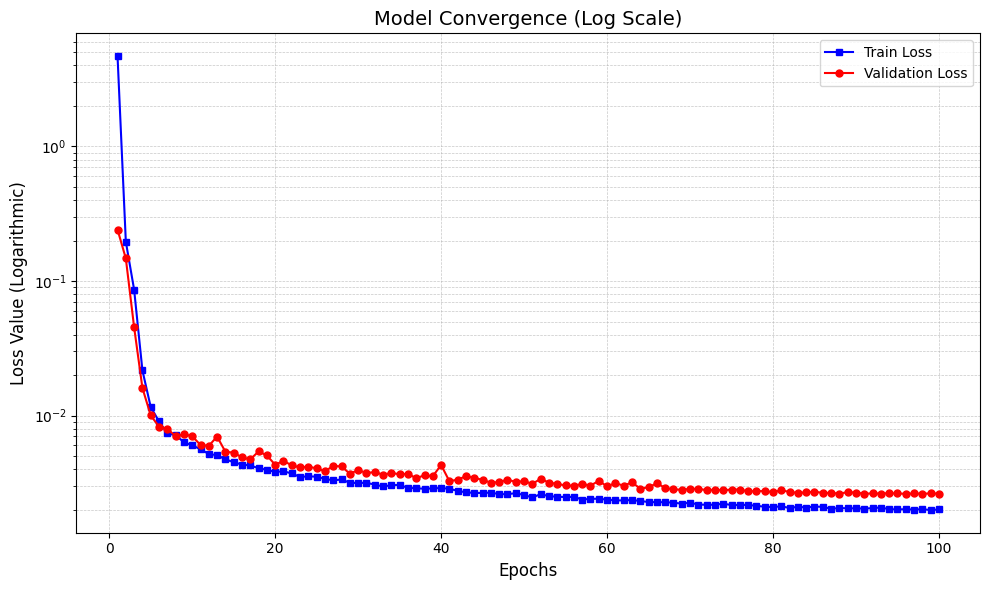

✅ Biểu đồ (Log Scale) đã được lưu tại: ./loss_chart.png


In [24]:
plot_history(history, "./loss_chart.png")